In [1]:
import pandas as pd

In [2]:
# Load the dataset
file_path = "../data/epl_results.csv"
data = pd.read_csv(file_path, encoding="ISO-8859-1")
data.head()

,Season,DateTime,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR
0,1993-94,1993-08-14T00:00:00Z,Arsenal,Coventry,0,3,A,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1993-94,1993-08-14T00:00:00Z,Aston Villa,QPR,4,1,H,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1993-94,1993-08-14T00:00:00Z,Chelsea,Blackburn,1,2,A,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1993-94,1993-08-14T00:00:00Z,Liverpool,Sheffield Weds,2,0,H,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1993-94,1993-08-14T00:00:00Z,Man City,Leeds,1,1,D,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
data.Season.unique()

array(['1993-94', '1994-95', '1995-96', '1996-97', '1997-98', '1998-99',
       '1999-00', '2000-01', '2001-02', '2002-03', '2003-04', '2004-05',
       '2005-06', '2006-07', '2007-08', '2008-09', '2009-10', '2010-11',
       '2011-12', '2012-13', '2013-14', '2014-15', '2015-16', '2016-17',
       '2017-18', '2018-19', '2019-20', '2020-21', '2021-22'],
      dtype=object)

In [3]:
df = data.copy()

In [4]:
# Basic data cleaning and preprocessing
df = df[["Season", "DateTime", "HomeTeam", "AwayTeam", "FTHG", "FTAG"]]
df["DateTime"] = pd.to_datetime(df["DateTime"])

# Extract year and month for season analysis
df["Year"] = df["DateTime"].dt.year
df["Month"] = df["DateTime"].dt.month

# Calculate rolling average goals for home and away teams
df["HomeTeamGoals"] = df.groupby("HomeTeam")["FTHG"].transform(
    lambda x: x.rolling(10, 1).mean()
)
df["AwayTeamGoals"] = df.groupby("AwayTeam")["FTAG"].transform(
    lambda x: x.rolling(10, 1).mean()
)

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PoissonRegressor

# Create feature and target df
X = df[["HomeTeamGoals", "AwayTeamGoals"]]
y_home = df["FTHG"]
y_away = df["FTAG"]

# Split the data into training and testing sets
X_train, X_test, y_train_home, y_test_home, y_train_away, y_test_away = (
    train_test_split(X, y_home, y_away, test_size=0.2, random_state=42)
)

In [6]:
# Train the Poisson regression model for home and away goals
model_home = PoissonRegressor()
model_home.fit(X_train, y_train_home)

model_away = PoissonRegressor()
model_away.fit(X_train, y_train_away)

PoissonRegressor()

In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Predict goals on the test set
y_pred_home = model_home.predict(X_test)
y_pred_away = model_away.predict(X_test)

# Calculate evaluation metrics
mse_home = mean_squared_error(y_test_home, y_pred_home)
mae_home = mean_absolute_error(y_test_home, y_pred_home)
mse_away = mean_squared_error(y_test_away, y_pred_away)
mae_away = mean_absolute_error(y_test_away, y_pred_away)

print(f"Home Goals Prediction - MSE: {mse_home}, MAE: {mae_home}")
print(f"Away Goals Prediction - MSE: {mse_away}, MAE: {mae_away}")

Home Goals Prediction - MSE: 1.4880040302834336, MAE: 0.9768504487655336
Away Goals Prediction - MSE: 1.233381744003515, MAE: 0.8616287492441428


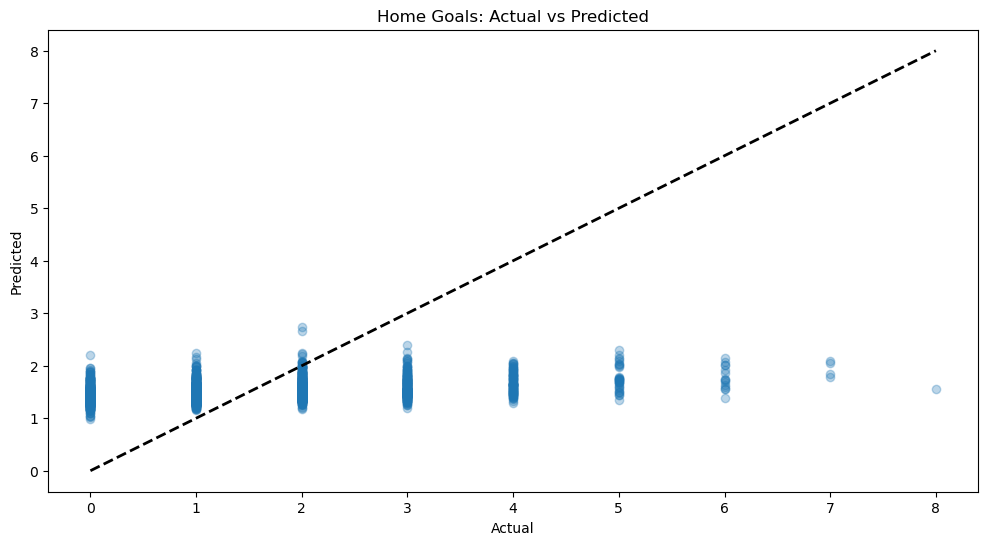

In [8]:
import matplotlib.pyplot as plt

# Plot predicted vs actual values for home goals
plt.figure(figsize=(12, 6))
plt.scatter(y_test_home, y_pred_home, alpha=0.3)
plt.plot(
    [y_test_home.min(), y_test_home.max()],
    [y_test_home.min(), y_test_home.max()],
    "k--",
    lw=2,
)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Home Goals: Actual vs Predicted")
plt.show()

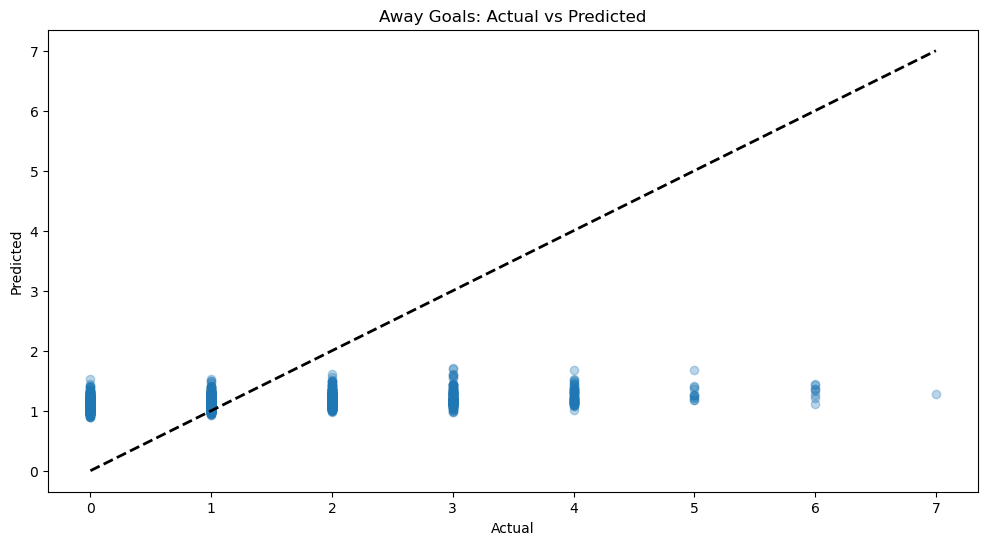

In [9]:
# Plot predicted vs actual values for away goals
plt.figure(figsize=(12, 6))
plt.scatter(y_test_away, y_pred_away, alpha=0.3)
plt.plot(
    [y_test_away.min(), y_test_away.max()],
    [y_test_away.min(), y_test_away.max()],
    "k--",
    lw=2,
)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Away Goals: Actual vs Predicted")
plt.show()

In [10]:


# Function to predict goals
def predict_goals(home_team, away_team):
    home_goals = df[df["HomeTeam"] == home_team]["HomeTeamGoals"].values[-1]
    away_goals = df[df["AwayTeam"] == away_team]["AwayTeamGoals"].values[-1]
    pred_home_goals = model_home.predict([[home_goals, away_goals]])[0]
    pred_away_goals = model_away.predict([[home_goals, away_goals]])[0]
    return pred_home_goals, pred_away_goals

In [12]:
import streamlit as st

# Streamlit app
st.title("EPL Goals Prediction")

# Select teams
home_team = st.selectbox("Select Home Team", df["HomeTeam"].unique())
away_team = st.selectbox("Select Away Team", df["AwayTeam"].unique())

# Predict button
if st.button("Predict"):
    pred_home_goals, pred_away_goals = predict_goals(home_team, away_team)
    st.write(f"Predicted goals for {home_team}: {pred_home_goals:.2f}")
    st.write(f"Predicted goals for {away_team}: {pred_away_goals:.2f}")

2024-07-15 02:34:23.508 
  command:

    streamlit run /Users/donginkim/anaconda3/envs/py311/lib/python3.11/site-packages/ipykernel_launcher.py [ARGUMENTS]
2024-07-15 02:34:23.509 Session state does not function when running a script without `streamlit run`


## XGBOOST

In [11]:
import xgboost as xgb

# Create feature and target df
X = df[["HomeTeamGoals", "AwayTeamGoals"]]
y_home = df["FTHG"]
y_away = df["FTAG"]

# Split the df into training and testing sets
X_train, X_test, y_train_home, y_test_home, y_train_away, y_test_away = (
    train_test_split(X, y_home, y_away, test_size=0.2, random_state=42)
)

# Train the XGBoost model for home and away goals
model_home = xgb.XGBRegressor(objective="reg:squarederror")
model_home.fit(X_train, y_train_home)

model_away = xgb.XGBRegressor(objective="reg:squarederror")
model_away.fit(X_train, y_train_away)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [12]:
# Predict goals on the test set
y_pred_home = model_home.predict(X_test)
y_pred_away = model_away.predict(X_test)

# Calculate evaluation metrics
mse_home = mean_squared_error(y_test_home, y_pred_home)
mae_home = mean_absolute_error(y_test_home, y_pred_home)
mse_away = mean_squared_error(y_test_away, y_pred_away)
mae_away = mean_absolute_error(y_test_away, y_pred_away)

print(f"Home Goals Prediction - MSE: {mse_home}, MAE: {mae_home}")
print(f"Away Goals Prediction - MSE: {mse_away}, MAE: {mae_away}")

Home Goals Prediction - MSE: 1.4691631504984106, MAE: 0.9375685540923838
Away Goals Prediction - MSE: 1.1508841401675374, MAE: 0.8401076508664161


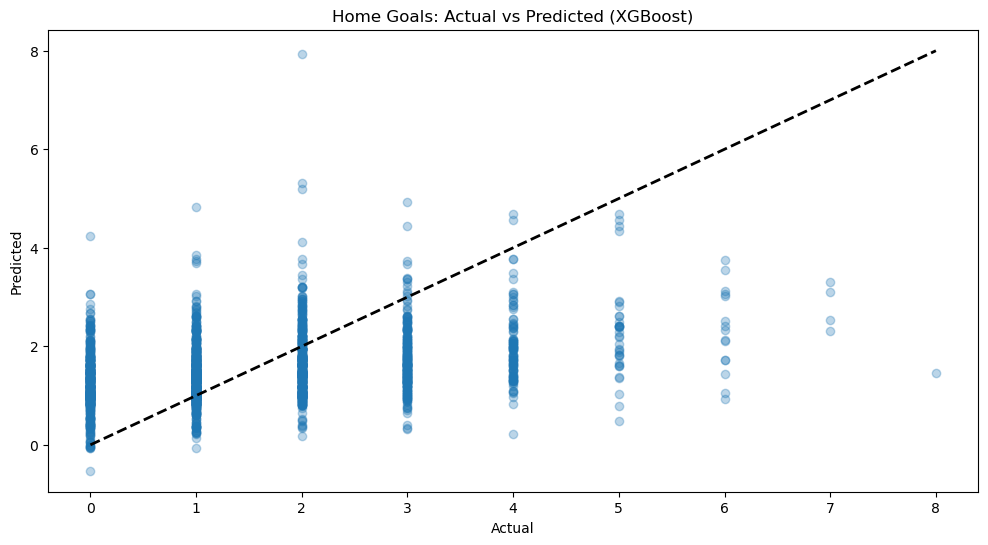

In [13]:
import matplotlib.pyplot as plt

# Plot predicted vs actual values for home goals
plt.figure(figsize=(12, 6))
plt.scatter(y_test_home, y_pred_home, alpha=0.3)
plt.plot(
    [y_test_home.min(), y_test_home.max()],
    [y_test_home.min(), y_test_home.max()],
    "k--",
    lw=2,
)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Home Goals: Actual vs Predicted (XGBoost)")
plt.show()

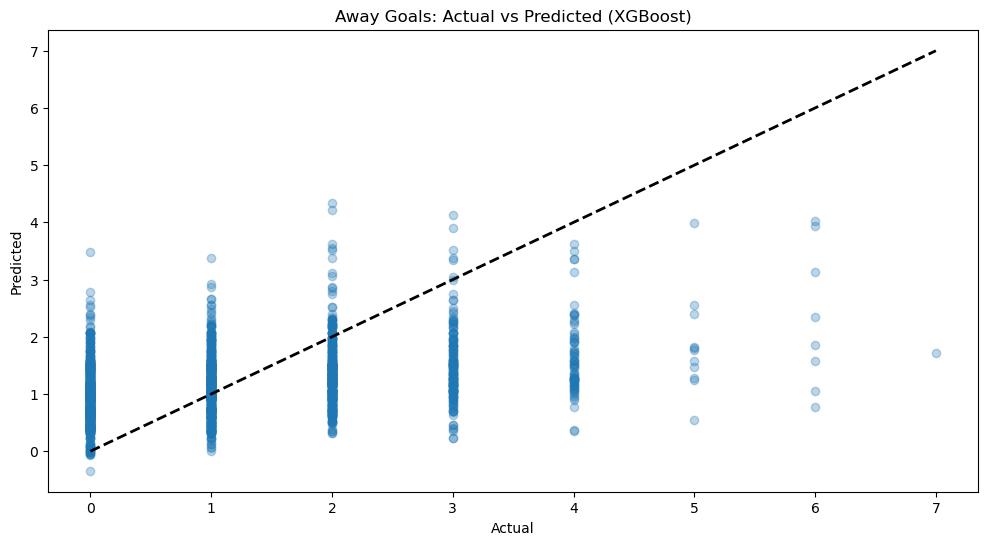

In [14]:
# Plot predicted vs actual values for away goals
plt.figure(figsize=(12, 6))
plt.scatter(y_test_away, y_pred_away, alpha=0.3)
plt.plot(
    [y_test_away.min(), y_test_away.max()],
    [y_test_away.min(), y_test_away.max()],
    "k--",
    lw=2,
)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Away Goals: Actual vs Predicted (XGBoost)")
plt.show()